# 📌 Clasificación de Spam en Correos Electrónicos  

Este proyecto implementa un modelo de **Machine Learning** para clasificar correos electrónicos en **Spam** o **Ham (no spam)**, utilizando **Naïve Bayes** con **TF-IDF Vectorizer**.  

---

## 🔹 1. Preprocesamiento del Dataset  

Antes de entrenar el modelo, realizamos una serie de pasos clave para mejorar la calidad y el equilibrio de los datos.  

### 📍 División del dataset en clases: Ham y Spam  
El dataset contiene dos categorías de correos electrónicos:  

- **Ham**: Correos legítimos.  
- **Spam**: Correos no deseados o maliciosos.  

Dado que la cantidad de correos spam es considerablemente alta, reducimos su muestra a aproximadamente un **tercio** de los datos originales. Esto es fundamental porque el algoritmo que utilizaremos, **TF-IDF Vectorizer**, es sensible a los desequilibrios en la cantidad de datos.  

---

## 🔹 2. ¿Qué es TF-IDF Vectorizer?  

**TF-IDF (Term Frequency-Inverse Document Frequency)** es una técnica utilizada en **Procesamiento de Lenguaje Natural (NLP)** para convertir texto en datos numéricos, permitiendo que los modelos de Machine Learning los interpreten.  

El cálculo de **TF-IDF** se basa en:  

- **Frecuencia en el documento (TF)**: Cuántas veces aparece una palabra en un correo electrónico.  
- **Frecuencia inversa en el corpus (IDF)**: Cuán común es esa palabra en todo el dataset.  

Palabras muy frecuentes pero poco relevantes (como "el", "un", "de") reciben un peso bajo, mientras que términos más específicos obtienen un mayor peso.  

❗ **Limitación:** TF-IDF **no tiene comprensión semántica**, lo que significa que no "entiende" el contexto real de las palabras.  

Por ejemplo, si en un correo aparece el mensaje:  

> *"Soy un rey nigeriano que te pide amablemente tu tarjeta de crédito a cambio de una recompensa."*  

El modelo solo verá un conjunto de palabras y su frecuencia, sin interpretar el posible intento de estafa.  

---

## 🔹 3. Balanceo del dataset  

Para evitar un sesgo en el modelo, realizamos un **balanceo de datos**:  

✅ **Reducimos la cantidad de correos Spam**, tomando solo un tercio de los datos originales.  
✅ **Mantenemos todos los correos Ham** para asegurar una buena representación de correos legítimos.  
✅ **El dataset final contiene aproximadamente 130,000 ejemplos** listos para el entrenamiento.  

---

## 🔹 4. Elección del Modelo: Naïve Bayes  

Para la clasificación de spam, utilizamos **Naïve Bayes**, un algoritmo basado en **probabilidad condicional**.  

### 📍 ¿Cómo funciona?  

Naïve Bayes calcula la probabilidad de que un correo sea spam dado que contiene ciertas palabras clave. Se basa en la siguiente ecuación de **probabilidad condicional**:  

\[
P(A | B) = \frac{P(B | A) \cdot P(A)}{P(B)}
\]  

Donde:  

- \( P(A | B) \) es la probabilidad de que el correo sea **spam**, dado que contiene ciertas palabras.  
- \( P(B | A) \) es la probabilidad de que esas palabras aparezcan en correos **spam**.  
- \( P(A) \) es la probabilidad de que un correo cualquiera sea **spam** en el dataset.  
- \( P(B) \) es la probabilidad general de que esas palabras aparezcan en cualquier correo.  

Naïve Bayes asume que las palabras son **independientes entre sí**, lo que simplifica el cálculo de probabilidades y permite un procesamiento rápido.  

### 📌 ¿Por qué Naïve Bayes?  

✔️ **Computacionalmente eficiente** → Funciona bien con grandes volúmenes de datos.  
✔️ **Rápido en entrenamiento y predicción** → Ideal para clasificación de texto.  
✔️ **Compatible con TF-IDF** → Puede manejar bien representaciones de texto numéricas.  

---


📌 **Próximos pasos:**  
- Probar con otros modelos como **SVM o Redes Neuronales**.  
- Implementar **Word Embeddings** para mejorar la comprensión semántica.  
- Optimizar el preprocesamiento del texto para mejorar la precisión del modelo.  

In [ ]:
'''
Descargar el dataset
'''

# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("meruvulikith/190k-spam-ham-email-dataset-for-classification")

# print("Path to dataset files:", path)

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import BernoulliNB
from html.parser import HTMLParser
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import f1_score, make_scorer

import seaborn as sn
import matplotlib.pyplot as plt
import pandas as pd
import string
import nltk

In [5]:
# Descargar las stopwords de nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/mvrick/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [6]:
# Cargar el dataset y aplicar preprocesamiento
data = pd.read_csv("dataset/spam_Emails_data.csv")


In [7]:
# Valores nulos
print(data['label'].value_counts())


label
Ham     102160
Spam     91692
Name: count, dtype: int64


In [8]:
# Filtrar valores nulos
data = data.dropna(subset=['text'])

In [9]:
print(data.isnull().sum())  # Para ver la cantidad de NaN en cada columna

label    0
text     0
dtype: int64


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 193850 entries, 0 to 193851
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   label   193850 non-null  object
 1   text    193850 non-null  object
dtypes: object(2)
memory usage: 4.4+ MB


In [11]:
#Fraccionar el dataset
spam_data = data[data['label'] == 'Spam']
ham_data = data[data['label'] == 'Ham']


In [12]:
# Reducir la muestra de Spam a la tercer parte (por ejemplo, de 90,000 a 30000)
spam_data_sample = spam_data.sample(n=int(len(spam_data) * 0.33), random_state=42)


In [13]:
# Combinar de nuevo el conjunto de datos balanceado
data_balanced = pd.concat([ham_data, spam_data_sample]).sample(frac=1, random_state=42)  # Mezclar aleatoriamente


In [14]:
# Clase para eliminar etiquetas HTML
class MLStripper(HTMLParser):
    def __init__(self):
        super().__init__()
        self.fed = []

    def handle_data(self, d):
        self.fed.append(d)

    def get_data(self):
        return ''.join(self.fed)

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

In [15]:
# Clase para el preprocesamiento
class Parser:
    def __init__(self):
        self.stemmer = nltk.PorterStemmer()
        self.stopwords = set(nltk.corpus.stopwords.words('english'))
        self.punctuation = list(string.punctuation)
    
    def tokenize(self, text):
        # Remover signos de puntuación y convertir en minúsculas
        for c in self.punctuation:
            text = text.replace(c, "")
        text = text.replace("\t", " ").replace("\n", " ")
        tokens = list(filter(None, text.lower().split(" ")))
        return [self.stemmer.stem(w) for w in tokens if w not in self.stopwords]

parser = Parser()

In [16]:
# Preprocesamiento y vectorización
data_balanced['processed_text'] = data_balanced['text'].apply(lambda x: " ".join(parser.tokenize(x)))


In [17]:
# Vectorización con TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data_balanced['processed_text'])
y = data_balanced['label']

In [18]:
# División en entrenamiento y prueba
from sklearn.model_selection import train_test_split

# División en tres conjuntos: entrenamiento (70%), prueba (20%) y producción (10%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_test, X_prod, y_test, y_prod = train_test_split(X_temp, y_temp, test_size=0.333, random_state=42, stratify=y_temp)

print("Tamaño de X_train:", X_train.shape)
print("Tamaño de X_test:", X_test.shape)
print("Tamaño de X_prod:", X_prod.shape)


Tamaño de X_train: (92691, 328693)
Tamaño de X_test: (26497, 328693)
Tamaño de X_prod: (13229, 328693)


## 🚀 Entrenamiento del Modelo  

Una vez completado el preprocesamiento del dataset, se procede a entrenar el modelo. En esta fase, se utiliza el algoritmo **Naïve Bayes Bernoulli**, acompañado de **GridSearchCV** para optimizar los hiperparámetros y mejorar el rendimiento del clasificador.  

---

### 🔹 1. Selección de la Métrica: F1-Score  

Dado que el problema de clasificación presenta un **desequilibrio en las clases**, es fundamental elegir una métrica adecuada que no favorezca a la clase mayoritaria. Para esto, se emplea el **F1-Score**, que combina dos métricas clave:  

- **Precisión:** Mide cuántos de los correos identificados como spam realmente lo son.  
- **Recall:** Indica cuántos de los correos spam fueron detectados correctamente por el modelo.  

El **F1-Score** es especialmente útil en este caso, ya que equilibra ambas métricas, evitando que el modelo sea demasiado conservador o demasiado permisivo en la clasificación de spam. Se configura de manera que **'Spam' sea la etiqueta positiva**, asegurando que la evaluación se centre en la correcta detección de correos no deseados.  

---

### 🔹 2. Ajuste de Hiperparámetros con GridSearchCV  

Para mejorar la precisión del modelo, se emplea **GridSearchCV**, una técnica que permite buscar automáticamente la mejor configuración de los hiperparámetros.  

El hiperparámetro clave en **Naïve Bayes Bernoulli** es **alpha (𝛼)**, que controla la **suavización de Laplace**. Este parámetro es fundamental, ya que afecta la manera en que el modelo maneja palabras poco frecuentes:  

- Valores **muy bajos** de 𝛼 hacen que el modelo sea demasiado sensible a términos raros, lo que puede generar sobreajuste.  
- Valores **muy altos** de 𝛼 pueden hacer que el modelo ignore términos relevantes, reduciendo su capacidad de generalización.  

Para encontrar el mejor valor de **𝛼**, **GridSearchCV** prueba distintas configuraciones mediante validación cruzada. Esto garantiza que el modelo se entrene con la mejor combinación posible, sin necesidad de realizar ajustes manuales.  

---

### 🔹 3. Validación Cruzada  

El proceso de ajuste de hiperparámetros incluye una técnica de **validación cruzada** con 5 divisiones (**CV=5**). Esto significa que el dataset se divide en cinco partes, entrenando el modelo en cuatro y validándolo en la quinta, de forma rotativa.  

Este procedimiento permite evaluar el desempeño del modelo en múltiples subconjuntos de datos, evitando que el resultado dependa demasiado de una única división. Como resultado, el modelo aprende a **generalizar mejor**, reduciendo el riesgo de sobreajuste.  

---

### 🔹 4. Razones para este Enfoque  

- **Uso del F1-Score:** Se elige esta métrica en lugar de precisión o recall por separado, ya que equilibra ambos factores y evita sesgos en la clasificación.  
- **Ajuste de 𝛼 con GridSearchCV:** Permite optimizar automáticamente el modelo, evitando la selección manual de hiperparámetros.  
- **Validación Cruzada:** Reduce la posibilidad de sobreajuste y mejora la capacidad de generalización del modelo.  



In [19]:
# Configurar el f1_score con la etiqueta positiva 'Spam'
f1_scorer = make_scorer(f1_score, pos_label='Spam')

In [20]:
# Ajuste de hiperparámetros con GridSearchCV
parameters = {'alpha': [0.01, 0.1, 0.5, 1.0]}
nb_clf = BernoulliNB()
grid_search = GridSearchCV(nb_clf, parameters, scoring=f1_scorer, cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=BernoulliNB(),
             param_grid={'alpha': [0.01, 0.1, 0.5, 1.0]},
             scoring=make_scorer(f1_score, response_method='predict', pos_label=Spam))

## 📊 Evaluación del Modelo  

Después de entrenar el modelo con **Naïve Bayes Bernoulli** y optimizarlo mediante **GridSearchCV**, se procede a evaluar su desempeño en el conjunto de prueba.  

---

### 🔹 1. Resultados Generales  

El modelo ha sido evaluado utilizando diferentes métricas para medir su capacidad de clasificación. Entre los resultados más relevantes, encontramos los siguientes:  

- **F1-Score (Spam):** 0.866  
- **F1-Score (Ham):** 0.957  
- **F1-Score Global:** 0.9115  
- **Precisión (Spam):** 0.813  
- **Recall (Spam):** 0.926  
- **ROC-AUC Score:** 0.978  

El **F1-Score Global**, que representa el promedio entre el rendimiento de ambas clases, es **0.9115**, lo que indica un balance adecuado entre precisión y recall.  

---

### 🔹 2. Análisis del Desempeño  

El modelo muestra un excelente desempeño en la clasificación de **correos Ham (legítimos)**, con un **F1-Score de 0.957**. Esto sugiere que el modelo es muy preciso al identificar correos legítimos, minimizando los **falsos positivos**.  

En la clasificación de **correos Spam**, el **F1-Score es 0.866**, con una **precisión de 0.813 y un recall de 0.926**. Esto implica que el modelo detecta la mayoría de los correos spam (alta sensibilidad), aunque ocasionalmente clasifica erróneamente algunos correos legítimos como spam.  

El **ROC-AUC Score de 0.978** indica que el modelo tiene una gran capacidad de discriminación entre correos legítimos y spam.  

---

### 🔹 3. Matriz de Confusión  

La matriz de confusión muestra el desglose de aciertos y errores en la clasificación:  

|   | Predicción: Ham | Predicción: Spam |  
|---|---------------|---------------|  
| **Real: Ham** | 19,157 | 1,285 |  
| **Real: Spam** | 451 | 5,604 |  

- **1,285 correos Ham fueron clasificados erróneamente como Spam (falsos positivos).**  
- **451 correos Spam fueron clasificados erróneamente como Ham (falsos negativos).**  

Aunque el modelo tiene un buen desempeño general, se podría seguir ajustando para reducir los **falsos positivos**, asegurando que menos correos legítimos sean detectados erróneamente como spam.  

---

### 🔹 4. Impacto del Tamaño del Dataset  

Se han realizado pruebas con distintos tamaños de dataset para analizar su impacto en el rendimiento del modelo:  

| Tamaño del dataset | F1-Score (Spam) |  
|------------------|-----------------|  
| 20,000 correos | 0.894 |  
| 50,000 correos | 0.904 |  
| 90,000 correos | 0.914 |  
| 130,000 correos (spam reducido al 30%) | 0.955 |  
| 130,000 correos (spam reducido en 1/3) | 0.957 |  
| 150,000 correos (spam reducido a la mitad) | 0.929 |  
| 190,000 correos | 0.921 |  

El mejor rendimiento se obtiene cuando el dataset tiene **130,000 ejemplos con el conjunto de spam reducido en un tercio**, alcanzando un **F1-Score de 0.957**. Esto sugiere que un **balance adecuado entre Ham y Spam** mejora significativamente la precisión del modelo.  

---

## 📌 Conclusión  

El modelo de **Naïve Bayes Bernoulli** ha demostrado ser efectivo para la clasificación de correos electrónicos en Ham y Spam, con un **F1-Score global de 0.9115** y un **ROC-AUC de 0.978**. La reducción y balanceo del dataset de Spam ha resultado clave para mejorar la precisión y recall del modelo.  

Si bien el rendimiento es alto, aún existe margen de mejora para reducir los **falsos positivos** y evitar que correos legítimos sean marcados como spam.  



In [23]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, confusion_matrix


In [21]:
# Predicción y evaluación (clase Ham)
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print('F1 score(clase positiva): {:.3f}'.format(f1_score(y_test, y_pred, pos_label='Ham')))

F1 score: 0.957


In [22]:
# Clase positiva

"""metricas = {
    "20k": 0.894,
    "50k": 0.904,
    "90k": 0.914,
    "130k": 0.955 con 0.3 de spam
    "130k": 0.957 pero con el ds dividido entre 3 
    "150k" 0.929 con la mitad del dataset de spam,
    "190k": 0.921
   }""" 

'metricas = {\n    "20k": 0.894,\n    "50k": 0.904,\n    "90k": 0.914,\n    "130k": 0.955 con 0.3 de spam\n    "130k": 0.957 pero con el ds dividido entre 3 \n    "150k" 0.929 con la mitad del dataset de spam,\n    "190k": 0.921\n   }'

In [24]:
# Predicciones y métricas de evaluación en el conjunto de prueba (clase Spam)
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]  # Probabilidades para la clase Spam


In [25]:
# F1-Score para evaluar la clase Spam
f1 = f1_score(y_test, y_pred, pos_label='Spam')
print(f'F1 Score: {f1:.3f}')


F1 Score: 0.866


In [26]:
# Precision y Recall
precision = precision_score(y_test, y_pred, pos_label='Spam')
recall = recall_score(y_test, y_pred, pos_label='Spam')
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')


Precision: 0.813
Recall: 0.926


In [27]:
# ROC-AUC
roc_auc = roc_auc_score(y_test.map({'Ham': 0, 'Spam': 1}), y_pred_proba)
print(f'ROC-AUC Score: {roc_auc:.3f}')


ROC-AUC Score: 0.978


In [28]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred, labels=['Ham', 'Spam'])
print("Confusion Matrix:\n", cm)


Confusion Matrix:
 [[19157  1285]
 [  451  5604]]


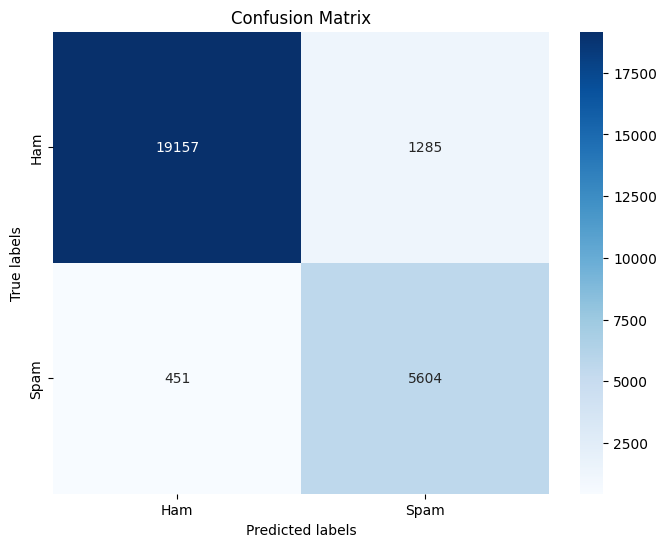

In [29]:
# Visualizar la matriz de confusión

plt.figure(figsize=(8, 6))
sn.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

<h2>Exportar el modelo (opcional)</h2>

In [31]:
import joblib

# Guardar el modelo
joblib.dump(best_model, 'model/spam_classifier.pkl')
# Guardar el vectorizador
joblib.dump(vectorizer, 'model/tfidf_vectorizer.pkl')


['model/tfidf_vectorizer.pkl']

<h2>Evaluar en modelo exportado con la fraccion del dataset del 10% </h2>
<h3>(opcional)</h3>

In [40]:
# Cargar el modelo y el vectorizador
model_classifier = joblib.load('model/spam_classifier.pkl')
vectorizer = joblib.load('model/tfidf_vectorizer.pkl')


In [41]:
# Predicciones en el conjunto de producción
y_prod_pred = model_classifier.predict(X_prod)  # Predicciones finales
y_prod_pred_proba = model_classifier.predict_proba(X_prod)[:, 1]  # Probabilidades para `Spam`

In [42]:
# Métricas conjuntas (considerando ambas clases: Ham y Spam)
roc_auc_prod = roc_auc_score(y_prod.map({'Ham': 0, 'Spam': 1}), y_prod_pred_proba)

In [43]:
# Métricas específicas para la clase `Spam`
f1_prod_spam = f1_score(y_prod, y_prod_pred, pos_label='Spam')
precision_prod_spam = precision_score(y_prod, y_prod_pred, pos_label='Spam')
recall_prod_spam = recall_score(y_prod, y_prod_pred, pos_label='Spam')

In [44]:
# Métricas específicas para la clase `Ham`
f1_prod_ham = f1_score(y_prod, y_prod_pred, pos_label='Ham')
precision_prod_ham = precision_score(y_prod, y_prod_pred, pos_label='Ham')
recall_prod_ham = recall_score(y_prod, y_prod_pred, pos_label='Ham')

In [45]:
# Matriz de confusión
cm_prod = confusion_matrix(y_prod, y_prod_pred, labels=['Ham', 'Spam'])

In [46]:
# Resultados y desglose explícito
print("=== Métricas conjuntas ===")
print(f"ROC-AUC Score (Ambas clases): {roc_auc_prod:.3f}")

=== Métricas conjuntas ===
ROC-AUC Score (Ambas clases): 0.979


In [47]:
print("\n=== Métricas por clase ===")
print(f"Clase 'Spam':")
print(f"  F1 Score: {f1_prod_spam:.3f}")
print(f"  Precisión: {precision_prod_spam:.3f}")
print(f"  Recall: {recall_prod_spam:.3f}")


=== Métricas por clase ===
Clase 'Spam':
  F1 Score: 0.872
  Precisión: 0.822
  Recall: 0.928


In [48]:
print(f"\nClase 'Ham':")
print(f"  F1 Score: {f1_prod_ham:.3f}")
print(f"  Precisión: {precision_prod_ham:.3f}")
print(f"  Recall: {recall_prod_ham:.3f}")


Clase 'Ham':
  F1 Score: 0.959
  Precisión: 0.978
  Recall: 0.941


In [49]:
print("\n=== Matriz de Confusión ===")
print("Matriz de Confusión:")
print(cm_prod)
print("\nDesglose de la matriz de confusión:")
print(f"  Ham correctamente clasificados (TN): {cm_prod[0][0]}")
print(f"  Ham clasificados como Spam (FP): {cm_prod[0][1]}")
print(f"  Spam clasificados como Ham (FN): {cm_prod[1][0]}")
print(f"  Spam correctamente clasificados (TP): {cm_prod[1][1]}")


=== Matriz de Confusión ===
Matriz de Confusión:
[[9599  607]
 [ 219 2804]]

Desglose de la matriz de confusión:
  Ham correctamente clasificados (TN): 9599
  Ham clasificados como Spam (FP): 607
  Spam clasificados como Ham (FN): 219
  Spam correctamente clasificados (TP): 2804


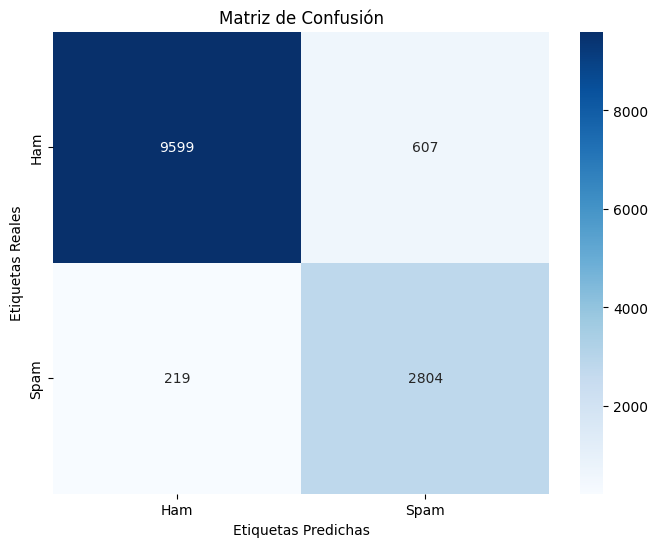

In [50]:
# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm_prod, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel("Etiquetas Predichas")
plt.ylabel("Etiquetas Reales")
plt.title("Matriz de Confusión")
plt.show()